## MNIST 데이터를 이용한 분류 연습

### 3.1 MNIST

In [1]:
import numpy as np
import pandas as pd

In [2]:
from sklearn.datasets import fetch_openml

In [3]:
#MNIST 데이터 불러오기
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [4]:
X,y = mnist['data'], mnist['target']

In [5]:
X.shape

(70000, 784)

In [6]:
y.shape

(70000,)

In [7]:
import matplotlib as mpl
import matplotlib.pyplot as plt

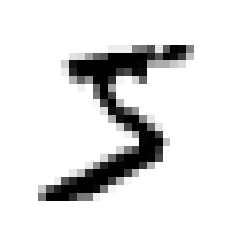

In [8]:
some_digit = X[0]
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image, cmap = 'binary')
plt.axis('off')
plt.show()

In [9]:
y[0]

'5'

In [10]:
#레이블이 문자형이기때문에 숫자형으로 변환
y = y.astype(np.uint8)

In [11]:
#train, test 데이터로 나누기
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

### 3.2 이진 분류기 훈련

In [12]:
#분류를 위한 target 벡터 만들기
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [13]:
from sklearn.linear_model import SGDClassifier

In [14]:
sgd_clf = SGDClassifier(random_state = 42)
sgd_clf.fit(X_train, y_train_5) #이진 분류기라 5로 라벨링 된 데이터만 다룸

SGDClassifier(random_state=42)

In [15]:
#모델 이용해서 숫자 5의 이미지 감지
sgd_clf.predict([some_digit])

array([ True])

### 3.3 성능 측정

3.3.1 교차 검증을 이용한 정확도 측정

In [16]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

In [17]:
#stratified k-fold
skfolds = StratifiedKFold(n_splits = 3, random_state =  42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct/len(y_pred))

C:\Users\Yoonhee\Anaconda3\envs\yoonhee\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


0.95035
0.96035
0.9604


In [18]:
from sklearn.model_selection import cross_val_score

In [19]:
#cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring = 'accuracy')

array([0.95035, 0.96035, 0.9604 ])

In [20]:
#모든 이미지를 '5아님' 클래스로 분류하는 더미 분류기를 만들어 비교해보기
from sklearn.base import BaseEstimator

In [21]:
class Never5Classifier(BaseEstimator):
    def fit(self,X,y=None):
        return self
    def predict(self,X):
        return np.zeros((len(X),1), dtype = bool)

In [22]:
never_5_clf = Never5Classifier()

In [23]:
cross_val_score(never_5_clf, X_train, y_train_5, cv = 3, scoring='accuracy')
#이미지의 10% 정도가 5이기 때문에, '5아님'으로는 90% 정도의 정확도를 가질 수 있다.

array([0.91125, 0.90855, 0.90915])

3.3.2 오차 행렬

In [24]:
from sklearn.model_selection import cross_val_predict

In [25]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)   ###왜 cross_val_predict 사용...?

In [26]:
from sklearn.metrics import confusion_matrix

In [27]:
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

In [28]:
#완벽한 분류기인 경우
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

3.3.3 정밀도와 재현율

In [29]:
from sklearn.metrics import precision_score, recall_score

In [30]:
precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [31]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [32]:
#F1 score
from sklearn.metrics import f1_score

In [33]:
f1_score(y_train_5, y_train_pred)

0.7325171197343846

3.3.4 정밀도/재현율 트레이드오프

In [34]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [35]:
threshold = 0 #임곗값이 0인 경우
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [36]:
threshold = 8000 #임곗값이 8000인 경우
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [37]:
# 적절한 임곗값 설정하는 법
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method = 'decision_function') #훈련세트에 있는 모든 샘플의 점수 구하기(결정점수)

In [38]:
from sklearn.metrics import precision_recall_curve
#가능한 모든 임곗값에 대해 정밀도, 재현율 plot
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

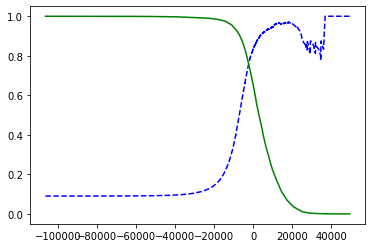

In [39]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label = '정밀도')
    plt.plot(thresholds, recalls[:-1], 'g-', label = '재현율')
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

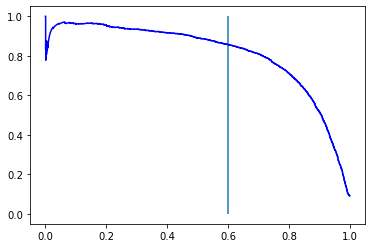

In [40]:
plt.plot(recalls[:-1], precisions[:-1], 'b-') #재현율과 정밀도 그래프
plt.vlines(0.6,0,1)
#

In [41]:
threshold_90_precision = thresholds[np.argmax(precisions>= 0.7)]
threshold_90_precision

-3590.6216868820206

In [45]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

precision_score(y_train_5, y_train_pred_90)
recall_score(y_train_5, y_train_pred_90)

0.8088913484596938

3.3.5 ROC 곡선

In [46]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores) #FPR, TPR 먼저 계산

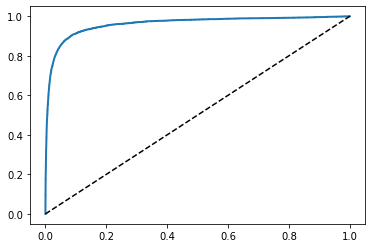

In [47]:
def plot_roc_curve(fpr,tpr, label=None):
    plt.plot(fpr, tpr, linewidth =2, label =label)
    plt.plot([0,1],[0,1],'k--')
    
plot_roc_curve(fpr,tpr)
plt.show()

In [48]:
#AUC 면적 계산
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

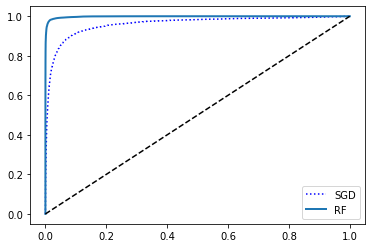

In [50]:
#Random Forest Classifier의 ROC, AUC
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state = 42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv = 3, method = 'predict_proba') #predict_proba: 샘플이 행, 클래스가 열이고 샘플이 주어진 클래스에 속할 확률을 담은 배열 반환

y_scores_forest = y_probas_forest[:,1] #양성 클래스에 대한 확률을 점수로 사용
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

plt.plot(fpr,tpr,'b:',label = 'SGD')
plot_roc_curve(fpr_forest, tpr_forest, 'RF')
plt.legend(loc='lower right')
plt.show()

### 3.4 다중분류

In [51]:
from sklearn.svm import SVC

In [52]:
#Support Vector Machine Classifier
svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digit]) 

array([5], dtype=uint8)

In [53]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores #결정계수가 가장 높은 클래스:5

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [54]:
np.argmax(some_digit_scores)

5

In [55]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [56]:
#OvO나 OvR을 강제로 사용하게 하도록 설정할 경우
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [57]:
#SGD Classifier 훈련
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [58]:
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [60]:
#cross val score 이용해서 정확도 평가
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring = 'accuracy')

array([0.87365, 0.85835, 0.8689 ])

In [61]:
#scale 조정으로 정확도 높이기
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring='accuracy')

array([0.8983, 0.891 , 0.9018])

### 3.5 에러분석

In [62]:
#confusion matrix
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv = 3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx 

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]],
      dtype=int64)

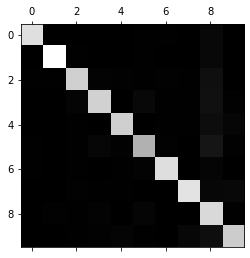

In [63]:
#confusion matrix 이미지화(행: 실제 클래스, 열: 예측 클래스)
plt.matshow(conf_mx, cmap = plt.cm.gray)
plt.show()
#5 부분이 진한 이유:1) 5의 데이터 수 자체가 적어서, 2) 분류기가 숫자 5를 다른 숫자만큼 분류를 못해서

In [64]:
#1)이 맞나를 따져보기 위해
#에러비율(오차행렬의 각 값을 대응되는 클래스의 이미지 개수로 나눈 값) plot(행: 실제 클래스, 열: 예측 클래스)
row_sums = conf_mx.sum(axis = 1, keepdims = True)
norm_conf_mx = conf_mx/row_sums

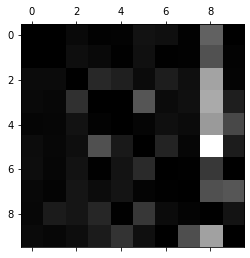

In [66]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap = plt.cm.gray)
plt.show() 
#예측 클래스 8이 밝은 것으로 보아 8로 잘못 분류된 이미지가 많은듯
#그에 반해 실제 클래스 8은 어두운 것으로 보아

### 3.6 다중 레이블 분류

In [68]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train %2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd] #첫번째는 숫자가 7보다 크거나 같은지, 두번째는 홀수인지를 나타내는 multilabel

In [69]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [71]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [73]:
#다중레이블을 평가하는 방법
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average = 'macro')
#가중치가 다른 경우는 average = 'weighted' 로 설정하면 됨

0.976410265560605

### 3.7 다중 출력 분류

In [75]:
noise = np.random.randint(0,100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0,100, (len(X_test), 784))
X_test_mod  = X_test + noise
y_train_mod = X_train
y_test_mod = X_test